In [1]:
'''
Steps:

1- Camera calibration
2- Distortion correction
3- Color/gradient threshold
4- Perspective transform

5- Detect lane lines
6- Determine the lane curvature
'''

'\nSteps:\n\n1- Camera calibration\n2- Distortion correction\n3- Color/gradient threshold\n4- Perspective transform\n\n5- Detect lane lines\n6- Determine the lane curvature\n'

In [26]:
import cv2
import glob
import os
import random
import time
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Camera Calibration, Undistortion Correction

In [3]:
def calibrateCameraR(images, nx, ny, image_shape):
    imagePoints = []
    objectPoints = []
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    for file in images:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            imagePoints.append(corners)
            objectPoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    return cv2.calibrateCamera(objectPoints, imagePoints, image_shape[:2], None, None)

def calibrateCamera(images, nx, ny, image_shape):
    imagePoints = []
    objectPoints = []
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    for image in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            imagePoints.append(corners)
            objectPoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    return cv2.calibrateCamera(objectPoints, imagePoints, image_shape[:2], None, None)

def undistortImage(image, mtx, dist):
    x = cv2.undistort(image, mtx, dist, None, mtx)
    return x

## Testing Calibration and Undistortion (Chessboard images)

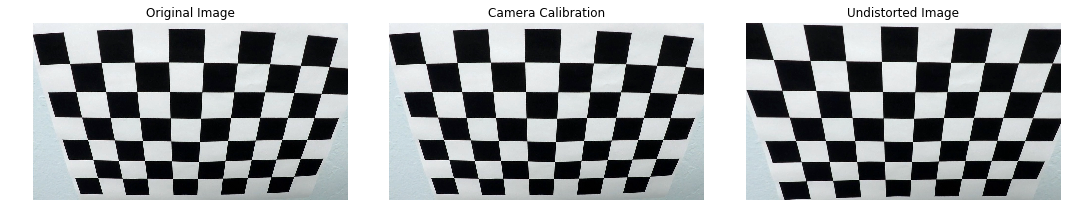

Time Elapsed: 10.820243999999999 sec.


In [4]:
t = time.clock()

images = glob.glob('./camera_cal/calibration*.jpg')

idx = random.randint(0, len(images)-1)
idx = 11

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
f.tight_layout()

sample = cv2.imread(images[idx])
ax1.imshow(sample)
ax1.axis('off')
ax1.set_title('Original Image')

ret, mtx, dist, rvecs, tvecs = calibrateCameraR(images, nx=9, ny=6, image_shape=sample.shape)

sample2 = cv2.imread(images[idx])
ax2.imshow(sample2)
ax2.axis('off')
ax2.set_title('Camera Calibration')

sample3 = undistortImage(sample2, mtx, dist)
ax3.imshow(sample3)
ax3.axis('off')
ax3.set_title('Undistorted Image')

plt.show()

print("Time Elapsed: " + str(time.clock() - t) + (" sec."))


# Color and Gradient Thresholding

## Functions Definition

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    x = 0
    y = 0
    if orient == 'x':
        x = 1
    else:
        y = 1
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    sobelabs = np.abs(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    soblenorm = np.uint8(255*sobelabs/np.max(sobelabs))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(soblenorm)
    # 6) Return this mask as your binary_output image
    binary_output[(soblenorm >= thresh[0]) & (soblenorm <= thresh[1])] = 1
    
    return binary_output
    

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelabsx = np.absolute(sobelx)
    sobelabsy = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(sobelabsy, sobelabsx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    # 6) Return this mask as your binary_output image
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    
    return binary_output

def combined_grad(sobx, soby, mag_binary, dir_binary):
    combined = np.zeros_like(dir_binary)
    combined[((sobx == 1) & (soby == 1) | (mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def s_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls_img[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

def combined_color(grad_combined, hls):
    ret = np.zeros_like(grad_combined)
    ret[(hls == 1) | (grad_combined == 1)] = 1
    return ret

# ======= A function that combines all the thresholds (gradient and color)
# and returns an image with the thresholds all on them ======== #
def gradColorThresh(image):
    sobx = abs_sobel_thresh(image, orient='x', thresh=(20,100))
    soby = abs_sobel_thresh(image, orient='y', thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30,100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    bin_grad = combined_grad(sobx, soby, mag_binary, dir_binary)
    hls = s_select(image, thresh=(200, 500))
    colorThresh = combined_color(bin_grad, hls)
    return colorThresh

## Part 1: Gradient Thresholding

Time Elapsed: 0.9721539999999997 sec.


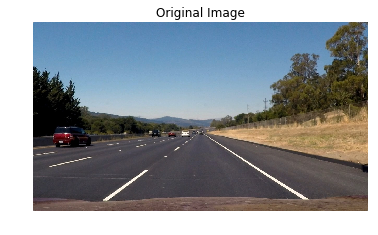

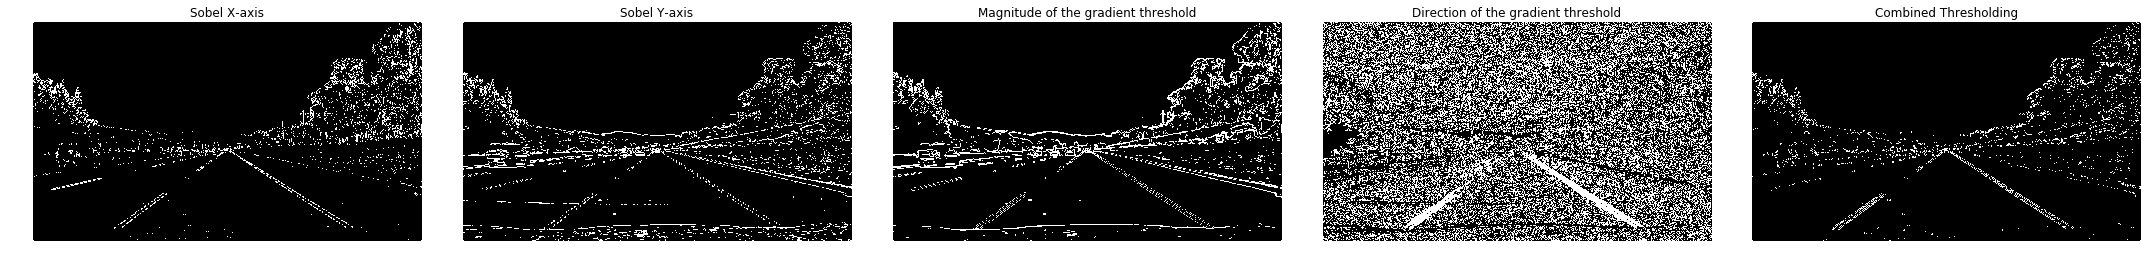

In [6]:
t = time.clock()

test_images = glob.glob('./test_images/*.jpg')

idx = 4
idx = random.randint(0, len(test_images)-1)
idx = 1

testgrad = cv2.imread(test_images[idx])
testgrad = cv2.cvtColor(testgrad, cv2.COLOR_BGR2RGB)
ax1 = plt.subplot(1,1,1)
ax1.imshow(testgrad)
ax1.set_title('Original Image')
ax1.axis('off')

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(30,30))
f.tight_layout()

# Testing the Gradient Thresholding
sobx = abs_sobel_thresh(testgrad, orient='x', thresh=(20, 100))
ax1.imshow(sobx, cmap='gray')
ax1.axis('off')
ax1.set_title('Sobel X-axis')

soby = abs_sobel_thresh(testgrad, orient='y', thresh=(20, 100))
ax2.imshow(soby, cmap='gray')
ax2.axis('off')
ax2.set_title('Sobel Y-axis')

mag_binary = mag_thresh(testgrad, sobel_kernel=9, mag_thresh=(30, 100))
ax3.imshow(mag_binary, cmap='gray')
ax3.axis('off')
ax3.set_title('Magnitude of the gradient threshold')

dir_binary = dir_threshold(testgrad, sobel_kernel=15, thresh=(0.7, 1.3))
ax4.imshow(dir_binary, cmap='gray')
ax4.axis('off')
ax4.set_title('Direction of the gradient threshold')

# Combined Gradient Thresholding
# ax5 = plt.subplot(1,1,1)
final1 = combined_grad(sobx, soby, mag_binary, dir_binary)
ax5.imshow(final1, cmap='gray')
ax5.axis('off')
ax5.set_title('Combined Thresholding')

print("Time Elapsed: " + str(time.clock() - t) + " sec.")

## Part 2: Color Thresholding

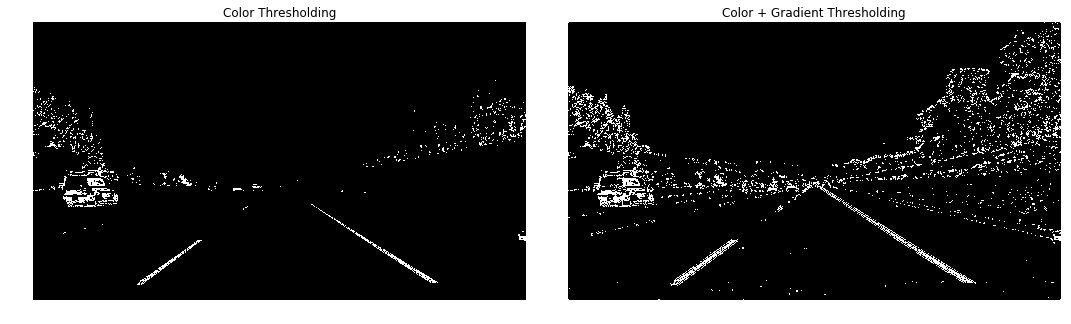

In [7]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
f.tight_layout()

hls = s_select(testgrad, thresh=(200, 500))
ax1.imshow(hls, cmap='gray')
ax1.axis('off')
ax1.set_title('Color Thresholding')

final2 = combined_color(final1, hls)
ax2.imshow(final2, cmap='gray')
ax2.axis('off')
ax2.set_title('Color + Gradient Thresholding')

# Perspective Transform

In [8]:
original_lane = np.asarray([[240, 686], [1060, 686], [738, 480], [545 ,480]], np.float32)
transformed_lane = np.asarray([[300, 700], [1000, 700], [1000 , 300], [300, 300]], np.float32)
def transform_perspective(img):
    undistorted_image = undistortImage(img, mtx, dist)
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(original_lane, transformed_lane)
    Minv = cv2.getPerspectiveTransform(transformed_lane, original_lane)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

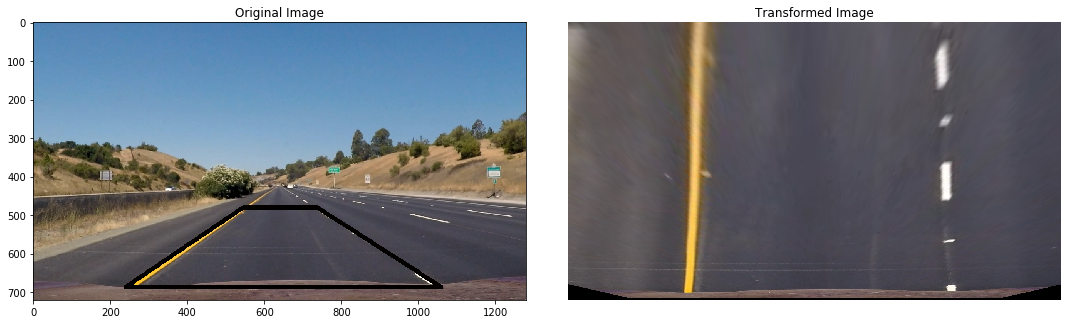

In [9]:
images = glob.glob('./test_images/*.jpg')

# idx = 1
idx = random.randint(0, len(images)-1)
img = cv2.imread(images[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = final2

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
f.tight_layout()

output, M, Minv = transform_perspective(img)

cv2.polylines(img,[np.asarray([original_lane], np.int32).reshape((-1,1,2))],True,3, 10)
ax1.imshow(img, cmap='gray')
ax2.axis('off')
ax1.set_title('Original Image')

ax2.imshow(output, cmap='gray')
ax2.axis('off')
ax2.set_title('Transformed Image')

# Lane Lines Detection

## Sliding Window - Part 1 : Histogram peaks

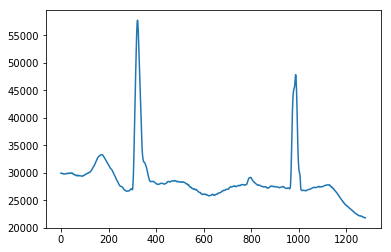

In [10]:
img = output
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Sliding Window - Part 2 : Searching for lane lines

In [11]:
def findLines_test(img, histogram):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    out_img = np.dstack((img,img,img))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 10
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, left_fitx, right_fitx, ploty
    #out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2RGB)

(720, 0)

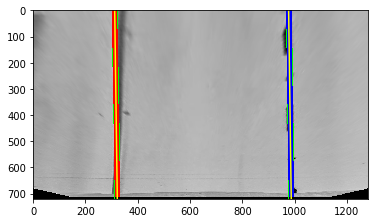

In [12]:
out_img, left_fitx, right_fitx, ploty = findLines_test(img, histogram)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Polynomial Fitting and Curvature Detection
## Implementation for the Line() class along with some helper functions.

In [31]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.windows = np.ones((5,12))*-1

def findCurv(ploty, fitx):
    y_eval = np.max(ploty)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
    
    return curverad

def findPos(pts, image_shape):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

def findMax(histo, xleft, xright):
    if len(histo[int(xleft):int(xright)]):
        return np.argmax(histo[int(xleft):int(xright)]) + xleft
    else:
        #return (xleft + xright) >> 1
        return (xleft + xright) / 2

def findMin(arr, x):
    if len(arr):
        return arr[(np.abs(arr-x)).argmin()]

def laneCheck(lane, curverad, fitx, fit):
    EPS = 0.6
    if lane.detected:
        if abs(curverad/lane.radius_of_curvature - 1) < EPS:
            lane.detected = True
            lane.bestx = np.mean(fitx)
            lane.current_fit = fit
            lane.radius_of_curvature = curverad
            lane.allx = fitx
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        if lane.radius_of_curvature:
            if abs(curverad / lane.radius_of_curvature - 1) < 1:
                lane.detected = True
                lane.bestx = np.mean(fitx)
                lane.current_fit = fit
                lane.radius_of_curvature = curverad
                lane.allx = fitx
            else:
                lane.detected = False
                fitx = lane.allx
        else:
            lane.detected = True
            lane.bestx = np.mean(fitx)
            lane.current_fit = fit
            lane.radius_of_curvature = curverad
            lane.allx = fitx
    return fitx

def findDirection(right, lastRight, lastRight2):
    if (abs(right-lastRight)/(lastRight-lastRight2) < 0.2):
        return right
    else:
        return lastRight + (lastRight - lastRight2)

leftLane = Line()
rightLane = Line()

def findLanes(image, nwindows, lanes, x_window, leftx, lefty, rightx, righty, windowidx):
    lastValues = np.zeros((nwindows+1, 2))
    lastValues[0] = [300, 1100]
    lastValues[1] = [300, 1100]
    left, right = (300, 1100)
    #center = (left + right) >> 1
    center = (left + right) / 2
    lastCenter = center
    dire = 0
    for i in range(nwindows-1):
        windowTop = 720-720/nwindows*(i+1)
        windowBottom = 720-720/nwindows*i
        if (not leftLane.detected) and (not rightLane.detected):
            hist = np.sum(image[image.shape[0]//2:, :], axis=0)
            left = findMax(hist, lastValues[i+1, 0]-200, lastValues[i+1, 0]+200)
            right = findMax(hist, lastValues[i+1, 1]-200, lastValues[i+1, 1]+200)

            left = findDirection(left, lastValues[i+1, 0], lastValues[i, 0])
            right = findDirection(right, lastValues[i+1, 1], lastValues[i, 1])
            
            lastCenter = center
            #center = (left + right) >> 1
            center = (left + right) / 2
            dire = center - lastCenter
        else:
            left = leftLane.windows[windowidx, i]
            right = rightLane.windows[windowidx, i]
        
        if abs(left-right) > 600:
            leftLaneArr = lanes[(lanes[:,1]>=left-x_window) & (lanes[:,1]<left+x_window) & (lanes[:,0]<=windowBottom) & (lanes[:,0]>=windowTop)]
            leftx += leftLaneArr[:,1].flatten().tolist()
            lefty += leftLaneArr[:,0].flatten().tolist()
            if not math.isnan(np.mean(leftLaneArr[:,1])):
                leftLane.windows[windowidx, i] = np.mean(leftLaneArr[:, 1])
                lastValues[i+2, 0] = lastValues[i+1, 0] + dire
            else:
                lastValues[i+2, 0] = lastValues[i+1, 0] + dire
                leftLane.windows[windowidx, i] = lastValues[i+2, 0]
                
            rightLaneArr = lanes[(lanes[:,1]>=right-x_window) & (lanes[:,1]<right+x_window) & (lanes[:,0]<windowBottom) & (lanes[:,0]>=windowTop)]
            rightx += rightLaneArr[:,1].flatten().tolist()
            righty += rightLaneArr[:,0].flatten().tolist()
            if not math.isnan(np.mean(rightLaneArr[:,1])):
                rightLane.windows[windowidx, i] = np.mean(rightLaneArr[:,1])
                lastValues[i+2, 1] = np.mean(rightLaneArr[:,1])
            else:
                lastValues[i+2, 1] = lastValues[i+1, 1] + dire
                rightLane.windows[windowidx, i] = lastValues[i+2, 1]
                
    return leftx, lefty, rightx, righty

def fitLanes(image):
    ploty = np.linspace(0, 100, num=101)*7.2
    lanes = np.argwhere(image)
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    curve = 0
    left = None
    right = None
    
    #iterations = random.randint(3,5)
    nWindows = random.randint(5,10)
    #i = 0
    for it in range(5):
        leftX, leftY, rightX, rightY = findLanes(image, nWindows, lanes, random.randint(25,100), leftX, leftY, rightX, rightY, it)
        if nWindows >= 9:
            nWindows = ((nWindows + 1) % 10) + random.randint(5,10)
        else:
            nWindows += 1
    
    leftFit = np.polyfit(leftY, leftX, 2)
    leftFitX = leftFit[0]*ploty**2+leftFit[1]*ploty + leftFit[2]
    rightFit = np.polyfit(rightY, rightX, 2)
    rightFitX = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
    
    leftCurverad = findCurv(ploty, leftFitX)
    rightCurverad = findCurv(ploty, rightFitX)
    
    leftFitX = laneCheck(leftLane, leftCurverad, leftFitX, leftFit)
    rightFitX = laneCheck(rightLane, rightCurverad, rightFitX, rightFit)
    
    return ploty, leftFitX, rightFitX, leftX, leftY, rightX, rightY, leftCurverad

def drawPolynomial(image, warped, ploty, leftFitX, rightFitX, leftX, leftY, rightX, rightY, perInv, curvature):
    placeholder = np.zeros_like(warped, dtype='uint8')
    colorWarp = np.dstack((placeholder, placeholder, placeholder))
    
    ptsLeft = np.array([np.transpose(np.vstack([leftFitX, ploty]))])
    ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitX, ploty])))])
    pts = np.hstack((ptsLeft, ptsRight))
    
    cv2.fillPoly(colorWarp, np.int_([pts]), (0, 255, 0))
    newWarp = cv2.warpPerspective(colorWarp, perInv, (image.shape[1], image.shape[0]))
    res = cv2.addWeighted(image, 1, newWarp, 0.3, 0)
    
    text = "Radius of Curvature " + str(int(curvature)) + " m"
    cv2.putText(res, text, (15, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    pts = np.argwhere(newWarp[:,:,1])
    pos = findPos(pts, image.shape)
    
    if (pos < 0):
        text2 = "{:.2f} m away from center to the left.".format(-pos)
    else:
        text2 = "{:.2f} m away from center to the right.".format(pos)
    cv2.putText(res, text2, (15, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    return res

# Pipeline
## For processing video frames in it.

In [37]:
def processImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    thresh = gradColorThresh(image)
    warp, M, Minv = transform_perspective(thresh)
    a, b, c, lx, ly, rx, ry, curvature = fitLanes(warp)
    return drawPolynomial(image, warp, a, b, c, lx, ly, rx, ry, Minv, curvature)

## Testing the pipeline and visualising the process

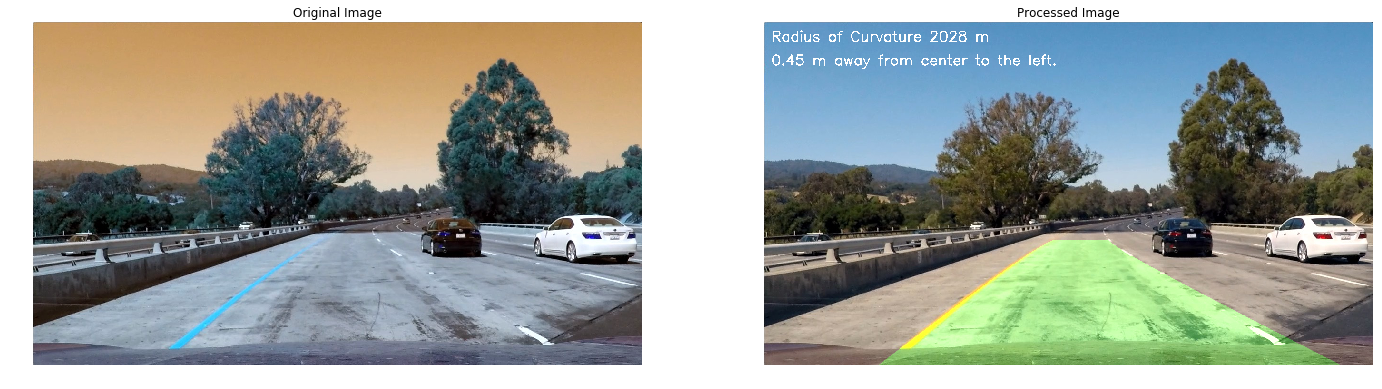

In [38]:
im = cv2.imread(images[random.randint(0, len(images)-1)])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(im)
ax1.axis('off')
ax1.set_title('Original Image')

pr = processImage(im)
ax2.imshow(pr)
ax2.axis('off')
ax2.set_title('Processed Image')

In [34]:
leftLane = Line()
rightLane = Line()

output1 = 'project_video_output.mp4'
clip = VideoFileClip('./project_video.mp4')
outputClip1 = clip.fl_image(processImage)

%time outputClip1.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [01:18<08:35,  2.15it/s]


 24%|██▍       | 303/1261 [02:24<06:41,  2.39it/s]


 36%|███▌      | 454/1261 [03:45<07:35,  1.77it/s]


 48%|████▊     | 605/1261 [05:26<09:05,  1.20it/s]


 60%|█████▉    | 756/1261 [07:06<03:48,  2.21it/s]


 72%|███████▏  | 907/1261 [08:30<03:12,  1.83it/s]


 84%|████████▍ | 1057/1261 [10:50<01:45,  1.94it/s]


 96%|█████████▌| 1205/1261 [12:08<00:30,  1.82it/s]


100%|█████████▉| 1260/1261 [12:41<00:00,  1.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 51s, sys: 2min 15s, total: 12min 6s
Wall time: 12min 43s
